# SANTANDER VALUE PREDICTION

DATSG08 FINAL PROJECT |
_Author: Ben Israel_

## Project Overview

According to Epsilon research, 80% of customers are more likely to do business with you if you provide personalized service. Banking is no exception.

The digitalization of everyday lives means that customers expect services to be delivered in a personalized and timely manner… and often before they´ve even realized they need the service. In their 3rd Kaggle competition, Santander Group aims to go a step beyond recognizing that there is a need to provide a customer a financial service and intends to determine the amount or value of the customer's transaction. This means anticipating customer needs in a more concrete, but also simple and personal way. With so many choices for financial services, this need is greater now than ever before.

The task here is to help Santander identify the value of transactions for each potential customer. This is a first step that Santander needs to nail in order to personalize their services at scale.

#### Data Description

You are provided with an anonymized dataset containing numeric feature variables, the numeric target column, and a string ID column.

The task is to predict the value of target column in the test set.

File descriptions

1. train.csv - the training set
2. test.csv - the test set 
3. sample_submission.csv - a sample submission file in the correct format

## 1. Data Exploration

In [561]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

import lightgbm as lgb

from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.model_selection import KFold, train_test_split

In [562]:
train_df = pd.read_csv('../Santander/train.csv')
test_df = pd.read_csv('../Santander/test.csv')
target_df = train_df['target']

In [563]:
train_df.head(10)

,ID,target,00000001,00000002,00000003,00000004,00000005,00000006,00000007,00000008,...,00004982,00004983,00004984,00004985,00004986,00004987,00004988,00004989,00004990,00004991
0,000d6aaf2,38000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
1,000fbd867,600000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
2,0027d6b71,10000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
3,0028cbf45,2000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
4,002a68644,14400000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
5,002dbeb22,2800000.0,0.0,0,0.0,0,0,0,0,0,...,12000.0,5600000.0,20000000.0,0,0,0,0,0,0,11000
6,003925ac6,164000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,40000,0,0,0
7,003eb0261,600000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
8,004b92275,979000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,4000000.0,0,0,0,0,0,0,0
9,0067b4fef,460000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,400000


In [564]:
print("The dimension for train_df (rows x cols) is: ", train_df.shape)
print("The dimension for test_df (rows x cols) is: ", test_df.shape)
print("The dimension for target_df (rows x cols) is: ", target_df.shape)

The dimension for train_df (rows x cols) is:  (4459, 4993)
The dimension for test_df (rows x cols) is:  (49342, 4992)
The dimension for target_df (rows x cols) is:  (4459,)


In [565]:
print('Sum of NAs in Train = ', train_df.isnull().sum(axis = 0).unique())
print('Sum of NAs in Test = ',  test_df.isnull().sum(axis = 0).unique())
print('Sum of NAs in Test = ',  test_df.isnull().sum(axis = 0).unique())

Sum of NAs in Train =  [0]
Sum of NAs in Test =  [0]
Sum of NAs in Test =  [0]


In [566]:
train_df.dtypes.value_counts()

int64      3147
float64    1845
object        1
dtype: int64

In [567]:
target_df.describe()

count    4.459000e+03
mean     5.944923e+06
std      8.234312e+06
min      3.000000e+04
25%      6.000000e+05
50%      2.260000e+06
75%      8.000000e+06
max      4.000000e+07
Name: target, dtype: float64

In [568]:
from collections import Counter
cnt = Counter(target_df)
cnt.most_common(20)

[(2000000.0, 207),
 (10000000.0, 199),
 (20000000.0, 156),
 (4000000.0, 148),
 (1000000.0, 129),
 (400000.0, 115),
 (200000.0, 113),
 (5000000.0, 101),
 (6000000.0, 88),
 (600000.0, 84),
 (8000000.0, 65),
 (3000000.0, 61),
 (800000.0, 59),
 (100000.0, 44),
 (40000.0, 40),
 (40000000.0, 40),
 (30000000.0, 39),
 (500000.0, 39),
 (1200000.0, 39),
 (300000.0, 37)]

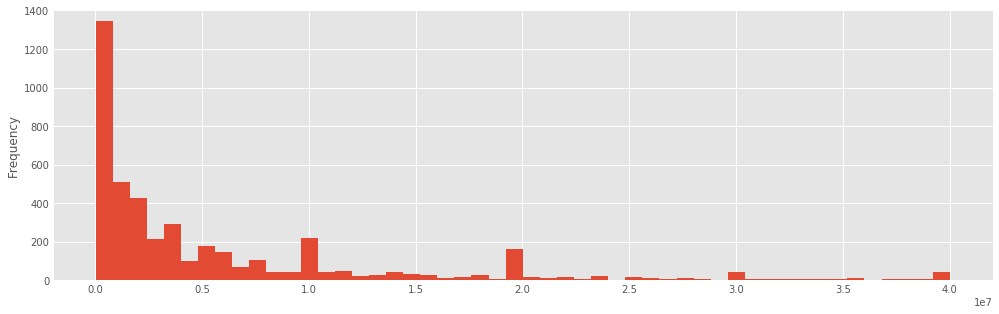

In [569]:
train_df['target'].plot(kind='hist', bins=50, figsize=[15,5])

In [570]:
len(train_df['target'].unique())

1413

## 2. Data Preparation

In [571]:
X_train = train_df.drop(["ID", "target"], axis=1)
y_train = np.log1p(train_df["target"].values)
X_test = test_df.drop(["ID"], axis=1)

In [572]:
colsToRemove = []
for col in X_train.columns:
    if X_train[col].std() == 0:
        colsToRemove.append(col)

In [573]:
X_train.drop(colsToRemove, axis=1, inplace=True)

print("Removed `{}` Constant Columns\n".format(len(colsToRemove)))

Removed `256` Constant Columns



In [574]:
X_test.drop(colsToRemove, axis=1, inplace=True)

print("Removed `{}` Constant Columns\n".format(len(colsToRemove)))

Removed `256` Constant Columns



In [575]:
colsToRemove = []
colsScaned = []
dupList = {}

columns = X_train.columns

for i in range(len(columns)-1):
    v = X_train[columns[i]].values
    dupCols = []
    for j in range(i+1,len(columns)):
        if np.array_equal(v, X_train[columns[j]].values):
            colsToRemove.append(columns[j])
            if columns[j] not in colsScaned:
                dupCols.append(columns[j]) 
                colsScaned.append(columns[j])
                dupList[columns[i]] = dupCols

In [576]:
X_train.drop(colsToRemove, axis=1, inplace=True)

print("Removed `{}` Constant Columns\n".format(len(colsToRemove)))

Removed `6` Constant Columns



In [577]:
X_test.drop(colsToRemove, axis=1, inplace=True)

print("Removed `{}` Constant Columns\n".format(len(colsToRemove)))

Removed `6` Constant Columns



In [578]:
print("The dimension for train_df (rows x cols) is: ", X_train.shape)
print("The dimension for test_df (rows x cols) is: ", X_test.shape)

The dimension for train_df (rows x cols) is:  (4459, 4730)
The dimension for test_df (rows x cols) is:  (49342, 4730)


In [579]:
clf_gb = GradientBoostingRegressor(random_state = 42)
clf_gb.fit(X_train, y_train)
print(clf_gb)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)


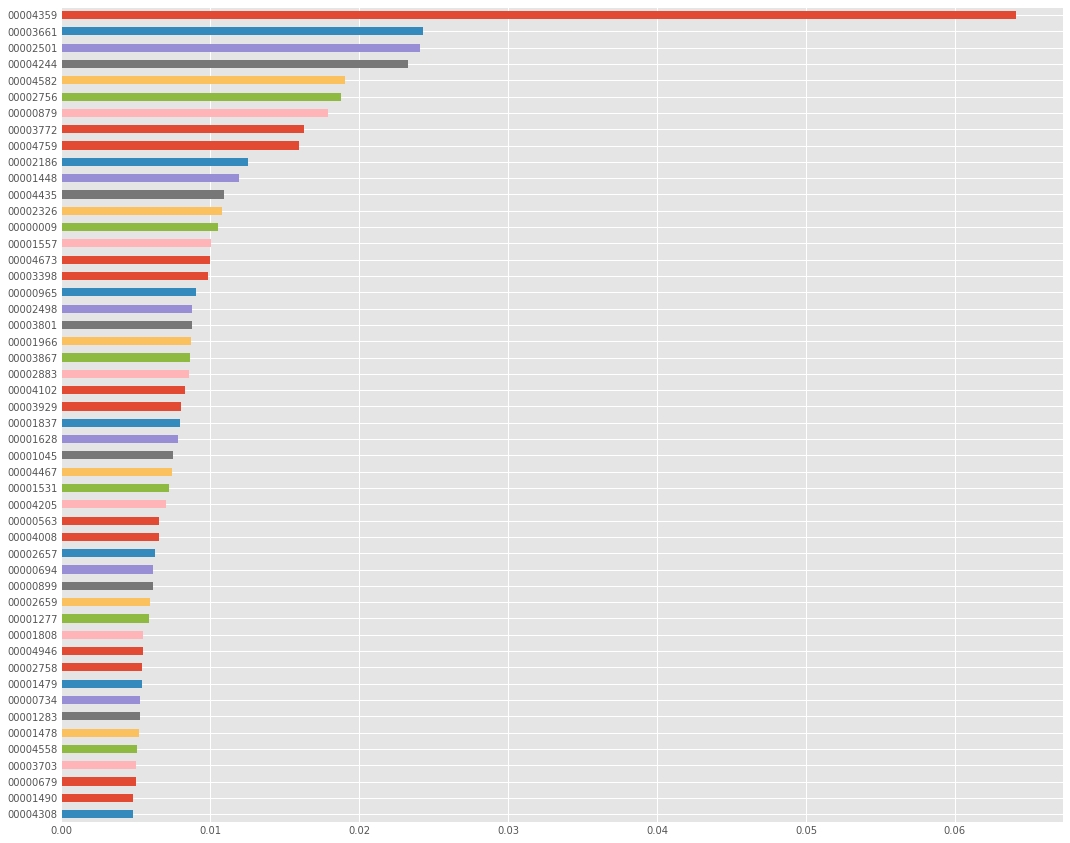

In [580]:
feat_importances = pd.Series(clf_gb.feature_importances_, index=X_train.columns)
feat_importances = feat_importances.nlargest(50)
plt.figure(figsize=(16,15))
feat_importances.plot(kind='barh')
plt.gca().invert_yaxis()
plt.show()

In [581]:
top_features = pd.Series(clf_gb.feature_importances_, index=X_train.columns).nlargest(15).index
print(top_features)

Index(['00004359', '00003661', '00002501', '00004244', '00004582', '00002756',
       '00000879', '00003772', '00004759', '00002186', '00001448', '00004435',
       '00002326', '00000009', '00001557'],
      dtype='object')


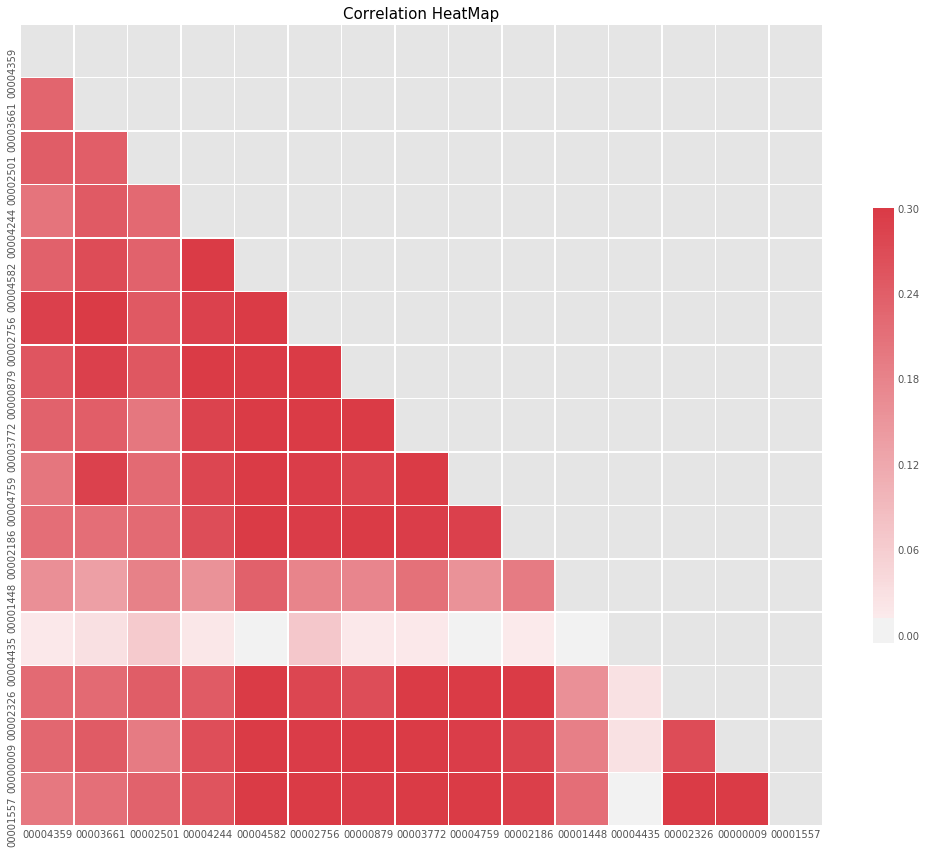

In [582]:
df_plot = pd.DataFrame(X_train, columns = top_features)
corr = df_plot.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(16, 16))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title("Correlation HeatMap", fontsize=15)
plt.show()

## 3. Data Modeling

### LightGBM model

In [583]:
dev_X, val_X, dev_y, val_y = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

In [584]:
lgb_train = lgb.Dataset(dev_X, dev_y, free_raw_data=False)
lgb_eval = lgb.Dataset(val_X, val_y, reference=lgb_train, free_raw_data=False)

In [585]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 40,
    'learning_rate': 0.005,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.7,
    'bagging_freq': 5,
    'verbose': -1
}

In [586]:
gbm = lgb.train(params, lgb_train, 5000, 
                      valid_sets=[lgb_eval], 
                      early_stopping_rounds=100, 
                      verbose_eval=50, 
                      evals_result=evals_result)


Training until validation scores don't improve for 100 rounds.
[50]	valid_0's rmse: 1.61662
[100]	valid_0's rmse: 1.55787
[150]	valid_0's rmse: 1.5133
[200]	valid_0's rmse: 1.48327
[250]	valid_0's rmse: 1.45955
[300]	valid_0's rmse: 1.44187
[350]	valid_0's rmse: 1.42928
[400]	valid_0's rmse: 1.42081
[450]	valid_0's rmse: 1.41474
[500]	valid_0's rmse: 1.41134
[550]	valid_0's rmse: 1.40878
[600]	valid_0's rmse: 1.40672
[650]	valid_0's rmse: 1.40604
[700]	valid_0's rmse: 1.40586
[750]	valid_0's rmse: 1.40596
[800]	valid_0's rmse: 1.406
[850]	valid_0's rmse: 1.40564
[900]	valid_0's rmse: 1.40613
Early stopping, best iteration is:
[839]	valid_0's rmse: 1.40549


In [587]:
y_pred = gbm.predict(val_X, num_iteration=gbm.best_iteration)

print('The rmse of prediction is:', mean_squared_error(val_y, y_pred) ** 0.5)

The rmse of prediction is: 1.4054949060060236


In [588]:
print("Features Importance...")
gain = model.feature_importance('gain')
featureimp = pd.DataFrame({'feature':model.feature_name(), 
                   'split':model.feature_importance('split'), 
                   'gain':100 * gain / gain.sum()}).sort_values('gain', ascending=False)
print(featureimp[:15])

Features Importance...
       feature      gain  split
4131  00004359  5.974588    641
4021  00004244  4.765295    571
2378  00002501  4.287443    662
3662  00003867  1.815586    210
3467  00003661  1.812327    344
3223  00003398  1.499174    374
8     00000009  1.441150    293
1459  00001531  1.432299    383
2616  00002756  1.360752    348
4186  00004415  1.241639    285
4344  00004582  1.174183    327
1484  00001557  1.099443    321
3572  00003772  0.965649    251
3471  00003665  0.935102    277
2056  00002159  0.883247     86


In [589]:
sub = pd.read_csv('../Santander/sample_submission.csv')
sub["target"] = pred_test
print(sub.head())
sub.to_csv('sub_lgb.csv', index=False)

          ID        target
0  000137c73  1.890963e+06
1  00021489f  1.784841e+06
2  0004d7953  2.605519e+06
3  00056a333  5.428303e+06
4  00056d8eb  1.988727e+06


### Ridge Regression Model

In [590]:
from sklearn.linear_model import Ridge
from sklearn import metrics

ridgereg = Ridge(alpha=0.1, normalize=True)

ridgereg.fit(dev_X, dev_y)

Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=True, random_state=None, solver='auto', tol=0.001)

In [591]:
y_pred = ridgereg.predict(val_X)
print(np.sqrt(metrics.mean_squared_error(val_y, y_pred))**0.5)

25.700846132454604


In [592]:
ridgereg = Ridge(alpha=0.5, normalize=True)
ridgereg.fit(dev_X, dev_y)
y_pred = ridgereg.predict(val_X)
print(np.sqrt(metrics.mean_squared_error(val_y, y_pred))**0.5)

23.00927678596524


In [593]:
list(zip(top_features, ridgereg.coef_))

[('00004359', 5.242086484221599e-09),
 ('00003661', -9.169163873868349e-08),
 ('00002501', 1.0489799495159685e-08),
 ('00004244', 2.289522503125296e-08),
 ('00004582', 6.757001896898436e-09),
 ('00002756', -1.4004319499547426e-08),
 ('00000879', 3.7416760618682524e-09),
 ('00003772', -6.210945276189355e-08),
 ('00004759', 3.955529893077942e-09),
 ('00002186', 1.2481330333982593e-09),
 ('00001448', -9.988100303569169e-11),
 ('00004435', 5.046672849396235e-05),
 ('00002326', 3.1479080637116555e-09),
 ('00000009', 1.1363031441345853e-10),
 ('00001557', 8.800011586411693e-10)]